Here, we aim to tune a model that predicts participant's group based on resting-state connectivity.

Limitations:

- SVC scores highest but cannot be explained quickly by the SHAP explainers.
- Tree-based models perform poorly on the data but are fast to explain using SHAP.

In [1]:
%reload_ext autoreload
%autoreload 3
import math
import numpy as np
import xarray as xr
import pandas as pd

import skopt
from skopt.space import Real, Categorical, Integer

from sklearn import feature_selection, svm, preprocessing, model_selection, ensemble
from sklearn import decomposition, dummy
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set('paper')
import plotly.express as px
from tqdm import tqdm

import xgboost
import lightgbm

from python.acnets.datasets.connectivity import load_connectivity


/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
X, y, feature_names = load_connectivity(
  parcellation='dosenbach2010',
  kind='tangent', # 'chatterjee' or 'precision'
  vectorize=True,
  return_y=True,
  only_diagonal=False,
  # binarization_threshold=1.0,
  return_feature_names=True,
  discard_diagonal=False,
  discard_cerebellum=False,)

# encode y as integers
y_encoder = preprocessing.LabelEncoder()
y = y_encoder.fit_transform(y)

# test/train splits
train, test = model_selection.train_test_split(
  range(len(X)),
  test_size=0.2,
  shuffle=True,
  stratify=y,)

In [3]:
# Pipeline candidates
pipe = Pipeline([
  ('select', 'passthrough'),
  ('zerovar', 'passthrough'),
  ('reduce', 'passthrough'),
  ('model', dummy.DummyClassifier())
], verbose=False)


# parameter spaces

rfc_param_space = {
  'select': [
    feature_selection.SelectFromModel(svm.SVC(), max_features=50),
  ],
  'select__estimator__C': Real(.1, 10000, prior='log-uniform'),
  'select__estimator__gamma': Real(.1, 10, prior='log-uniform'),
  'select__estimator__degree': Integer(1,8),
  'select__estimator__kernel': Categorical(['linear']), #, 'poly', 'rbf']),
  'model': [
    ensemble.RandomForestClassifier(
      bootstrap=True, oob_score=True, warm_start=False, n_jobs=-1)
  ],
  # 'reduce__n_components': Real(0.9, .999),
  # 'reduce__whiten': Categorical([False, True]),
  'model__n_estimators': Integer(10, 1000),
  'model__criterion': Categorical(['entropy', 'gini']),
  'model__max_features': Categorical([None, 'sqrt', 'log2']),
  'model__max_depth': Integer(10, 100),
}

svc_param_space = {
  'reduce': ['passthrough'],
  'model': [
    svm.SVC(probability=True)
  ],
  'model__C': Real(.1, 10000, prior='log-uniform'),
  'model__gamma': Real(.1, 10, prior='log-uniform'),
  'model__degree': Integer(1,8),
  'model__kernel': Categorical(['linear']), #, 'poly', 'rbf']),
}


xgb_param_space = {
  'model': [
    xgboost.XGBClassifier(
      verbosity=0,
      use_label_encoder=False,
      objective='binary:logistic', eval_metric='auc')
  ],
  # 'model__colsample_bylevel': Real(.6, .7),
  # 'model__colsample_bytree': Real(.6, .7),
  'model__gamma': Real(0, 1),
  'model__learning_rate': Real(.0001, 1),
  # 'model__max_delta_step': Real(.1, 10),  
  'model__max_depth': Integer(4, 100),
  # 'model__min_child_weight': Integer(10, 500),
  'model__n_estimators': Integer(10, 100),
  # 'model__reg_alpha': Real(0, 1),
  # 'model__reg_lambda': Real(0, 1),
  # 'model__subsample': Real(.5, .8),
  # 'model__objective': ['binary:hinge', 'binary:logistic'],
  # 'model__tree_method': ['exact', 'hist'],
}

lgbm_param_space = {
  'model': Categorical([
    lightgbm.LGBMClassifier(metric='auc', objective='binary', n_jobs=-1)
  ]),
  'model__n_estimators': Integer(1,100),
  'model__min_child_samples': Integer(1,10),
  'model__max_depth': Integer(-1,10),
  'model__num_leaves': Integer(2, 10),
  # 'model__early_stopping_rounds': [30],
  # 'model__min_data_in_leaf': [30, 50, 100, 300, 400],
  'model__reg_alpha': Real(0, .5),
  'model__reg_lambda': Real(0, .5)
}

gbc_param_space = {
  'model': Categorical([
    ensemble.GradientBoostingClassifier()
  ]),
  'model__max_depth': Integer(1, 5),
  'model__learning_rate': Real(10e-5, 1, 'log-uniform'),
  # 'model__max_features': Integer(1, 30),
  'model__min_samples_split': Integer(2, 30),
  'model__min_samples_leaf': Integer(1, 16)
}

Now optimize hyper-parameters, and see how the model performs.

In [4]:
opt = skopt.BayesSearchCV(
    pipe,
    [(rfc_param_space, 64)],
    n_points=1,
    scoring='roc_auc',
    verbose=0,
)

progress_bar = tqdm(total=opt.total_iterations)

opt.fit(
    X[train], y[train], callback=[
      skopt.callbacks.DeadlineStopper(total_time=300),
      lambda _: False if progress_bar.update() else False,
    ]
)

progress_bar.close()

best_model = opt.best_estimator_.named_steps['model']

print('best params:', opt.best_params_)
print('train score:', opt.best_score_)
print('test  score:', opt.score(X[test], y[test]))

cv_scores = model_selection.cross_val_score(
    opt.best_estimator_, X, y, n_jobs=-1, scoring='roc_auc',
    cv=model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=20))

print(f'5-Fold AUC (20 repeats): {cv_scores.mean():.3f}'
      f' \N{plus-minus sign} {cv_scores.std():.3f}')


 17%|█▋        | 11/64 [00:45<03:36,  4.08s/it]/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
 25%|██▌       | 16/64 [01:07<04:04,  5.09s/it]/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This 

best params: OrderedDict([('model', RandomForestClassifier(max_depth=57, max_features='log2', n_estimators=574,
                       n_jobs=-1, oob_score=True)), ('model__criterion', 'gini'), ('model__max_depth', 57), ('model__max_features', 'log2'), ('model__n_estimators', 574), ('select', SelectFromModel(estimator=SVC(C=5.601393304189775, degree=7,
                              gamma=2.495549718730111, kernel='linear'),
                max_features=50)), ('select__estimator__C', 5.601393304189775), ('select__estimator__degree', 7), ('select__estimator__gamma', 2.495549718730111), ('select__estimator__kernel', 'linear')])
train score: 0.8666666666666666
test  score: 1.0
5-Fold AUC (20 repeats): 0.839 ± 0.149


In [5]:
# print selected features ordered by importance

feature_selector = opt.best_estimator_.named_steps['select']
X_select = feature_selector.transform(X)
feature_names_sel = feature_names[feature_selector.get_support()]

rfc_importance_scores = opt.best_estimator_.named_steps['model'].feature_importances_

df = pd.DataFrame({
  'region': feature_names_sel,
  'rfc_importance': rfc_importance_scores
})
df.sort_values('rfc_importance', ascending=False)

,region,rfc_importance
22,ACC 21 ↔ inf cerebellum 121,0.066783
1,post occipital 158 ↔ inf cerebellum 151,0.064843
7,vFC 40,0.054785
42,occipital 141 ↔ vmPFC 7,0.044138
41,occipital 141 ↔ ACC 14,0.039249
15,IPS 114,0.035716
3,fusiform 81,0.035039
30,parietal 97 ↔ vlPFC 15,0.031015
39,occipital 137,0.026402
12,occipital 119 ↔ mid insula 55,0.023828


In [6]:
import shap

cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
n_splits = cv.get_n_splits(X, y)

cv_shaps = []

from copy import deepcopy

model = opt.best_estimator_.named_steps['model']
print(model)

for cv_train, cv_test in tqdm(cv.split(X_select, y), total=n_splits):
  
  model.fit(X_select[cv_train], y[cv_train])

  explainer = shap.TreeExplainer(
    model, X_select[cv_train],
    feature_names=feature_names_sel)

  sh = explainer(X_select[cv_test], y[cv_test], check_additivity=False)
  cv_shaps.append(deepcopy(sh))


shap_values = shap.Explanation(
  values = np.vstack([sh.values[...,1] for sh in cv_shaps]),
  base_values = np.hstack([sh.base_values[...,1] for sh in cv_shaps]),
  data = np.vstack([sh.data for sh in cv_shaps]),
  feature_names=cv_shaps[0].feature_names,
  compute_time=np.sum([sh.compute_time for sh in cv_shaps]),
  output_names=y_encoder.classes_,
)

RandomForestClassifier(max_depth=57, max_features='log2', n_estimators=574,
                       n_jobs=-1, oob_score=True)


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


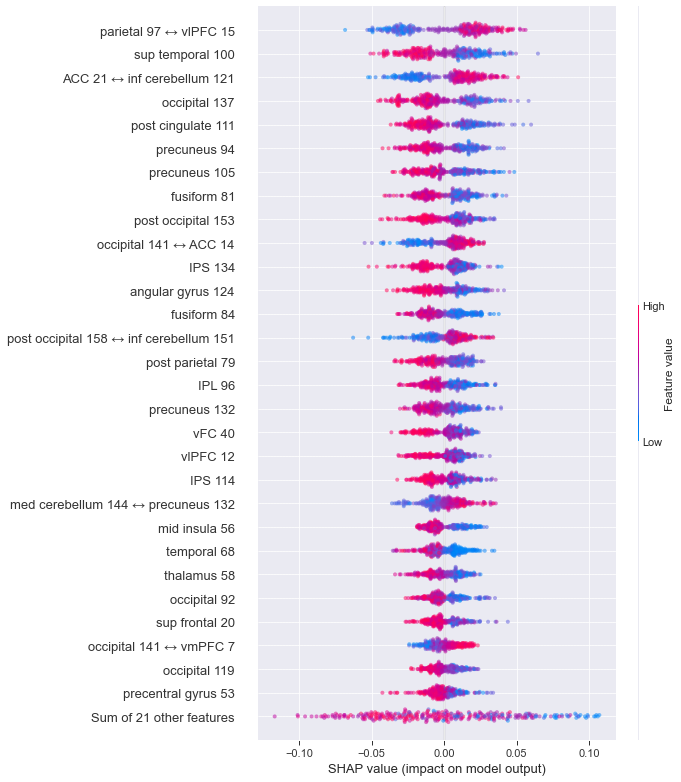

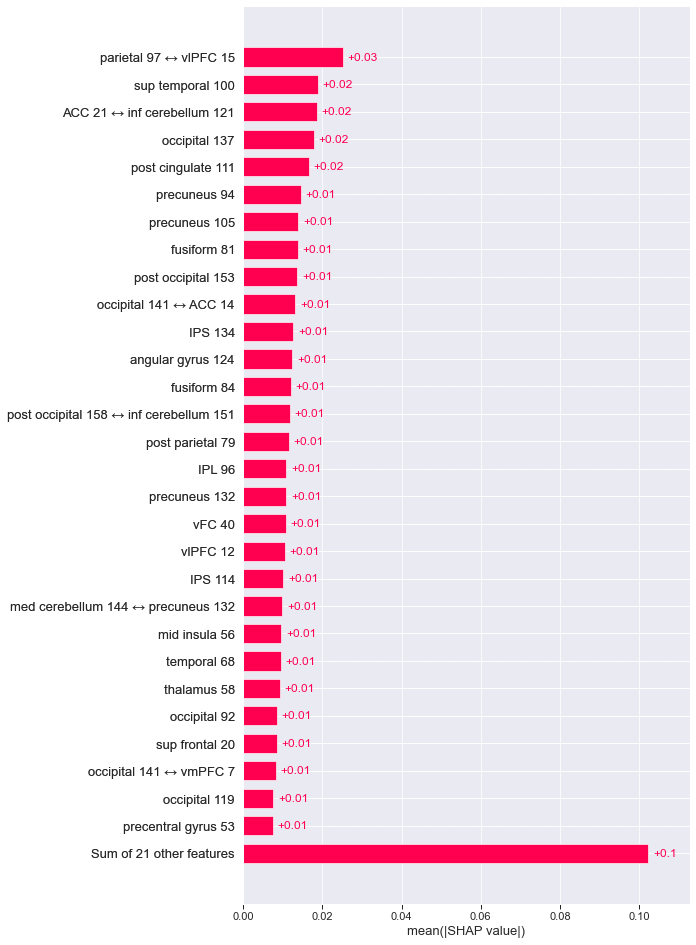

In [7]:

shap.plots.beeswarm(deepcopy(shap_values), alpha=.5, max_display=30)
shap.plots.bar(deepcopy(shap_values), max_display=30)